In [1]:
from nn_hmc_3d import NN_HMC
import dill
import numpy as np
import IPython
import jax.random as random
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import h5py
from igm_emulator.emulator.plotVis import v_bins
from igm_emulator.emulator.emulator_run import nn_emulator
import os
from progressbar import ProgressBar
'''
load model and auto-corr
'''
redshift = 5.4

# get the appropriate string and pathlength for chosen redshift
zs = np.array([5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
z_idx = np.argmin(np.abs(zs - redshift))
z_strings = ['z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z6']
z_string = z_strings[z_idx]
in_path_hdf5 = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/'
f = h5py.File(in_path_hdf5 + f'z{redshift}_nn_savefile.hdf5', 'r')
emu_name = f'{z_string}_best_param_training_768.p'
#IPython.embed()

best_params = dill.load(open(in_path_hdf5 + emu_name, 'rb'))
meanX = np.asarray(f['data']['meanX'])
stdX = np.asarray(f['data']['stdX'])
meanY = np.asarray(f['data']['meanY'])
stdY =  np.asarray(f['data']['stdY'])
print(meanX)
#best_params = load(f)
#print(f['performance']['residuals'])
#print(f['best_params']['custom_linear/~/linear_0']['w'])
#print(load(f'/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/z{redshift}_nn_savefile.hdf5'))

in_path = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{z_string}/final_135/'
n_paths = np.array([17, 16, 16, 15, 15, 15, 14]) #skewers_per_data
n_path = n_paths[z_idx]
vbins = v_bins
param_in_path = '/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/'
param_dict = dill.load(open(param_in_path + f'{z_string}_params.p', 'rb'))

fobs = param_dict['fobs']  # average observed flux <F> ~ Gamma_HI
log_T0s = param_dict['log_T0s']  # log(T_0) from temperature - density relation
T0s = np.power(10,log_T0s)
gammas = param_dict['gammas']  # gamma from temperature - density relation

T0_idx = 11 #0-14
g_idx = 4 #0-8
f_idx = 7 #0-8

like_name = f'likelihood_dicts_R_30000_nf_9_T{T0_idx}_G{g_idx}_SNR0_F{f_idx}_ncovar_500000_P{n_path}_set_bins_4.p'
like_dict = dill.load(open(in_path + like_name, 'rb'))
mock_name = f'mocks_R_30000_nf_9_T{T0_idx}_G{g_idx}_SNR0_F{f_idx}_P{n_path}_set_bins_4.p'
mocks = dill.load(open(in_path + mock_name, 'rb'))
theta_true = [fobs[f_idx], T0s[T0_idx], gammas[g_idx]]

mock_flux = mocks[0:5,:]
mean_flux = like_dict['mean_data']
print(mock_flux.shape)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Layers: [100, 100, 100, 276]
Activation: <PjitFunction of <function leaky_relu at 0x7f145ea6d040>>
L2 regularization lambda: 0.0001
meanX = [8.400e-02 9.149e+03 1.352e+00]
stdX = [1.36930639e-02 5.50374022e+03 6.02494813e-01]
train: (768, 3)
(358, 276)
[8.400e-02 9.149e+03 1.352e+00]
(5, 276)


In [2]:
print(theta_true)

[0.099, 14177.571428571428, 1.3520000000000003]


In [3]:
theta=jnp.array([theta_true,theta_true,theta_true])
theta_i=theta.squeeze()
print(theta)
print(theta.shape)
print(theta_i.shape)

[[9.90000000e-02 1.41775714e+04 1.35200000e+00]
 [9.90000000e-02 1.41775714e+04 1.35200000e+00]
 [9.90000000e-02 1.41775714e+04 1.35200000e+00]]
(3, 3)
(3, 3)


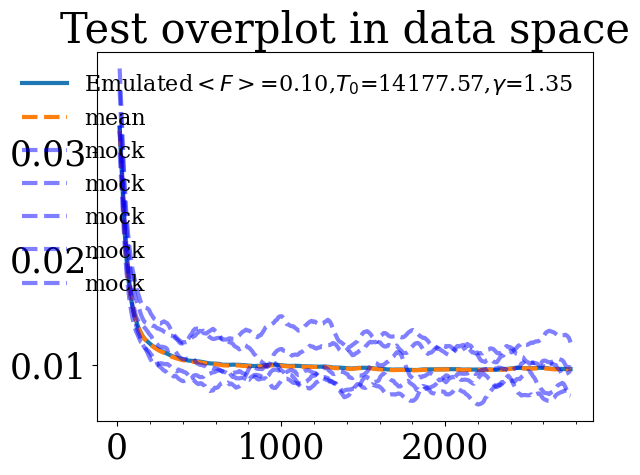

In [4]:
model = nn_emulator(best_params, theta_true)

fig2, axs2 = plt.subplots(1, 1)
axs2.plot(vbins, model, label=f'Emulated' r'$<F>$='f'{theta_true[0]:.2f},'
                                                     r'$T_0$='f'{theta_true[1]:.2f},'
                                                     r'$\gamma$='f'{theta_true[2]:.2f}')
axs2.plot(vbins, mean_flux, label=f'mean', linestyle='--')
for i in mock_flux:
    axs2.plot(vbins, i, label=f'mock', linestyle='--',alpha = 0.5, color ='blue')
plt.title('Test overplot in data space')
plt.legend()
plt.show()

In [5]:
    nn = NN_HMC(vbins,best_params,T0s,gammas,fobs,like_dict)
    x_true = nn.theta_to_x(theta_true)
    key = random.PRNGKey(642)
    key, subkey = random.split(key)

In [6]:
    #x_samples, theta_samples, ln_probs, neff, neff_mean, \
    #sec_per_neff, ms_per_step, r_hat, r_hat_mean, \
    #hmc_num_steps, hmc_tree_depth, runtime = nn.mcmc_one(key, x_true, flux)

In [7]:
import sys
sys.path.append('/home/zhenyujin/dw_inference/dw_inference/inference')
from utils import walker_plot, corner_plot


note = "jit_2000_4_test12_compare_molly_mock0"
var_label = ['fobs', 'T0s', 'gammas']

import sys
sys.path.append('/home/zhenyujin/wdm/correlation/')
from mcmc_inference_new_linda_params_mult_file_3d import return_idx, get_model_covar_nearest

read in fine model grid
0.0%
7.142857142857142%
14.285714285714285%
21.428571428571427%
28.57142857142857%
35.714285714285715%
42.857142857142854%
50.0%
57.14285714285714%
64.28571428571429%
71.42857142857143%
78.57142857142857%
85.71428571428571%
92.85714285714286%
done reading in


In [8]:
print(nn.potential_fun(theta_true),
nn.log_likelihood(theta_true),
nn.eval_prior(theta_true))

-2295.824344190421 2301.205218583609 -5.380874393188286


-2166.5173914485867 2171.898265841775 -5.380874393188286
true theta:[9.90000000e-02 1.41775714e+04 1.35200000e+00]
true x:[1.94591015e+00 1.29928298e+00 4.44089210e-16]


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.44it/s]


*** SUMMARY FOR HMC ***
total_time = 77.22233033180237 seconds for the HMC
total_steps = 22678 total steps
ms_per_step = 3.4051649321722537 ms per step of the HMC
n_eff_mean = 2181.6666666666665 effective sample size, compared to ntot = 4000 total samples.
ms_per_neff = 35.396 ms per effective sample
r_hat_mean = 1.0
max_tree_depth encountered = 5 in chain
There were 0 transitions that exceeded the max_tree_depth = (8, 10)
*************************


100% |###################################################################################################################################################################################################|


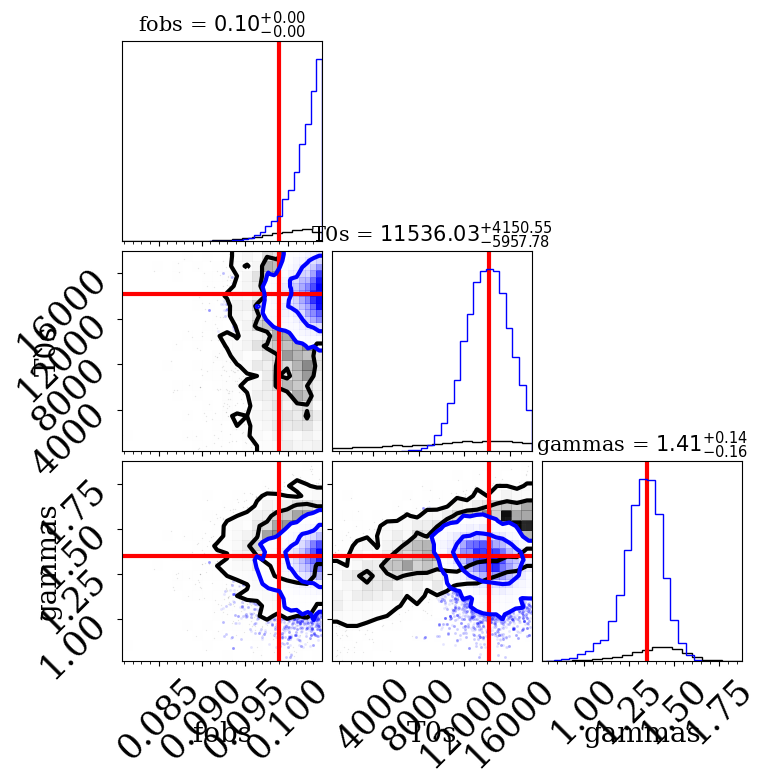

In [11]:
from nn_hmc_3d_x import NN_HMC_X
n_inference = 1
pbar = ProgressBar()
new_covariance = like_dict['covariance']
y_error = np.sqrt(np.diag(new_covariance))
molly_name = f'z54_data_nearest_model_set_bins_4_steps_48000_mcmc_inference_5_one_prior_T{T0_idx}_G{g_idx}_F{f_idx}_R_30000.hdf5'
molly_model = h5py.File(in_path + molly_name, 'r')
for mock_idx in pbar(range(n_inference)): 
    mock_idx = 3
    flux = mocks[mock_idx, :]
    nn_x = NN_HMC_X(vbins,best_params,T0s,gammas,fobs,like_dict)
    print(nn_x.potential_fun(x_true,flux),
    nn_x.log_likelihood(x_true,flux),
    nn_x.eval_prior(x_true))
    x_samples, theta_samples, lnP, neff, neff_mean, sec_per_neff, ms_per_step, r_hat, r_hat_mean, \
                hmc_num_steps, hmc_tree_depth, total_time = nn_x.mcmc_one(key, x_true, flux)
    
    f_mcmc, t_mcmc, g_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                 zip(*np.percentile(theta_samples, [16, 50, 84], axis=0)))

    molly_sample = molly_model['samples'][mock_idx,:,:]
    molly_flip = np.zeros(shape = molly_sample.shape)
    molly_flip[:,0] = molly_sample[:,2]
    molly_flip[:,1] = molly_sample[:,0]
    molly_flip[:,2] = molly_sample[:,1]

    t_molly, g_molly, f_molly = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                     zip(*np.percentile(molly_sample, [16, 50, 84], axis=0)))
    molly_infer, covar, log_det = get_model_covar_nearest([t_molly[0], g_molly[0],f_molly[0]])

    corner_fig = corner.corner(np.array(theta_samples),levels=(0.68, 0.95),labels=var_label,
                           truths=np.array(theta_true),truth_color='red',show_titles=True,
                          title_kwargs={"fontsize": 15}, label_kwargs={'fontsize': 20},
                            data_kwargs={'ms': 1.0, 'alpha': 0.1},)
    corner.corner(molly_flip,levels=(0.68, 0.95),fig=corner_fig,color='blue')

In [17]:
print(molly_model.keys())

molly_lnP = molly_model['log_prob'][mock_idx,:]
molly_evidence = np.sum(molly_model['log_prob'][mock_idx,:])
linda_evidence = np.sum(lnP)
print(molly_evidence,linda_evidence)
print(molly_lnP.max(),lnP.max())

<KeysViewHDF5 ['log_prob', 'samples', 'true_log_prob', 'true_theta']>
104249022.37162569 8662009.884829093
2173.6157867836446 2167.3270934745


In [10]:
import corner
fig = corner_plot(theta_samples, var_label,
            theta_true=jnp.asarray(theta_true),
            overlay_color = ['k'])
walker_plot(np.swapaxes(x_samples, 0, 1), var_label,
                    truths= jnp.asarray(x_true),
                    linewidth=1.0)

NameError: name 'theta_samples' is not defined

In [ ]:
import corner
fig = corner_plot(theta_samples, var_label,
            theta_true=jnp.asarray(theta_true),
            overlay_color = ['k'])
walker_plot(np.swapaxes(x_samples, 0, 1), var_label,
                    truths= jnp.asarray(x_true),
                    linewidth=1.0)

In [ ]:
from matplotlib.ticker import MaxNLocator
import matplotlib.patheffects as pe
from tabulate import tabulate
plt_params = {'legend.fontsize': 7,
                  'legend.frameon': False,
                  'axes.labelsize': 12,
                  'axes.titlesize': 12,
                  'figure.titlesize': 12,
                  'xtick.labelsize': 12,
                  'ytick.labelsize': 12,
                  'lines.linewidth': .7,
                  'lines.markersize': 2.3,
                  'lines.markeredgewidth': .9,
                  'errorbar.capsize': 2,
                  'font.family': 'serif',
                  # 'text.usetex': True,
                  'xtick.minor.visible': True,
                  }
x_size = 5
dpi_value = 200
plt.rcParams.update(plt_params)

fit_fig = plt.figure(figsize=(x_size*2., x_size*.65), constrained_layout=True,
                         dpi=dpi_value,
                         )
grid = fit_fig.add_gridspec(
        nrows=1, ncols=1,  # width_ratios=[3, 1, 1],
    )

fit_axis = fit_fig.add_subplot(grid[0])

inds = np.random.randint(len(theta_samples), size=100)
for idx, ind in enumerate(inds):
    sample = theta_samples[ind]
    model_plot = nn_emulator(best_params,sample)
    molly,co,log_d= get_model_covar_nearest(molly_sample[ind])
    if idx == 0:
        fit_axis.plot(vbins, model_plot, c="b", lw=.7, alpha=0.12, zorder=1, label='Posterior Draws')
        fit_axis.plot(vbins, molly, c="yellow", lw=.7, alpha=0.1, zorder=1, label='Old Posterior Draws')
    else:
        fit_axis.plot(vbins, model_plot, c="b", lw=.7, alpha=0.12, zorder=1)
        fit_axis.plot(vbins, molly, c="yellow", lw=.7, alpha=0.1, zorder=1)
            
max_P = max(lnP)
max_P_idx=[index for index, item in enumerate(lnP) if item == max_P]
print(f'max_P:{theta_samples[max_P_idx,:][0]}')
print(f'inferred:{[f_mcmc[0], t_mcmc[0], g_mcmc[0]]}')
inferred_model_plot = nn_emulator(best_params,[f_mcmc[0], t_mcmc[0], g_mcmc[0]])
max_P_model = nn_emulator(best_params,theta_samples[max_P_idx,:][0])
mean_flux = like_dict['mean_data']
fit_axis.plot(v_bins, inferred_model_plot, c="r", label='Inferred Model', zorder=5,lw=1,
                  path_effects=[pe.Stroke(linewidth=1.25, foreground='k'), pe.Normal()])
fit_axis.plot(v_bins, mean_flux, c="lightgreen", ls='--', label='True Model', zorder=2,lw=1.75,
                  path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
fit_axis.plot(v_bins, max_P_model, c="gold", label='Max Probability Model', zorder=3,lw=1,
                  path_effects=[pe.Stroke(linewidth=1.25, foreground='k'), pe.Normal()])
fit_axis.errorbar(v_bins, flux,
                      yerr=y_error,
                      color='k', marker='.', linestyle=' ', zorder=1, capsize=0,
                      label='Mock Data')
fit_axis.plot(v_bins, molly_infer, c="m", label='Old Model', zorder=4,lw=1,
                  path_effects=[pe.Stroke(linewidth=1.25, foreground='k'), pe.Normal()])
fit_axis.text(
        500, 0.0248,
        'True Model \n'+r'$\langle F \rangle$'+f' = {np.round(theta_true[0], decimals=4)}'+ f'\n $T_0$ = {int(theta_true[1])} K \n $\gamma$ = {np.round(theta_true[2], decimals=3)} \n',
        {'color': 'lightgreen', 'fontsize': 10},
    )

fit_axis.text(
        1000, 0.024,
        'Inferred Model \n'+r'$\langle F \rangle$'+f' = {np.round(f_mcmc[0], decimals=4)}$^{{+{np.round(f_mcmc[1], decimals=4)}}}_{{-{np.round(f_mcmc[2], decimals=4)}}}$'+
        f'\n $T_0$ = {int(t_mcmc[0])}$^{{+{int(t_mcmc[1])}}}_{{-{int(t_mcmc[2])}}}$ K' 
        f'\n '+r'$\gamma$'+f' = {np.round(g_mcmc[0], decimals=3)}$^{{+{np.round(g_mcmc[1], decimals=3)}}}_{{-{np.round(g_mcmc[2], decimals=3)}}}$\n',
        {'color': 'r', 'fontsize': 10},
    )
#fit_axis.text(
#        1510, 0.024,
#     'Old inferred Model \n'+r'$\langle F \rangle$'+f' = {np.round(f_molly[0], decimals=4)}$^{{+{np.round(f_molly[1], decimals=4)}}}_{{-{np.round(f_molly[2], decimals=4)}}}$'+
#       f'\n $T_0$ = {int(t_molly[0])}$^{{+{int(t_molly[1])}}}_{{-{int(t_molly[2])}}}$ K' 
#       f'\n '+r'$\gamma$'+f' = {np.round(g_molly[0], decimals=3)}$^{{+{np.round(g_molly[1], decimals=3)}}}_{{-{np.round(g_molly[2], decimals=3)}}}$\n',
#        {'color': 'm', 'fontsize': 10},
#   )
fit_axis.text(
        1510, 0.026,
      tabulate([[r' $R_2$', np.round(r2_score(flux, molly_infer), decimals=4),np.round(r2_score(flux, max_P_model), decimals=4)], 
                ['MSE', np.format_float_scientific(mean_squared_error(flux, molly_infer), precision=3),np.format_float_scientific(mean_squared_error(flux, max_P_model), precision=3)],
               ['Distance',np.format_float_scientific(minkowski(flux, molly_infer), precision=3),np.format_float_scientific(minkowski(flux, molly_infer), precision=3)]], headers=['Matrices','Grid','Emulator'],tablefmt='orgtbl'),
        {'color': 'm', 'fontsize': 10},
   )
fit_axis.set_xlim(vbins[0], vbins[-1])
fit_axis.set_xlabel("Velocity (km/s)")
fit_axis.set_ylabel("Correlation Function")
fit_axis.legend()

In [ ]:
out_path = '/home/zhenyujin/igm_emulator/igm_emulator/hmc/plots/'
#fit_fig.savefig(out_path + f'model_fit_{note}.pdf')
#corner_fig.savefig(out_path + f'corner_{note}.pdf')